# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
import random
from datetime import datetime, timedelta
import openpyxl
from openpyxl.styles import Alignment, Font
from openpyxl import load_workbook

# Creating Dummy Data

In [2]:
fake = Faker()
k=1000
case_no = list(range(1,999999))
case_type = ['Criminal', 'Civil', 'Legal']
case_status = ['Active', 'Pending', 'Resolved']
states = ['Uttar Pradesh', 'Maharashtra', 'Bihar', 'West Bengal', 'Madhya Pradesh']
districts = ['Lucknow', 'Mumbai', 'Patna', 'Kolkata', 'Bhopal']
date_of_registration = [fake.date_between(start_date='-1y', end_date='today') for _ in range(k)]
gender = ['M', 'F']
age = list(range(0, 101))
pre_trial_trial = [0, 1]
df = pd.DataFrame({
    'Case no': random.choices(case_no, k=k),
    'Case type': random.choices(case_type, k=k),
    'Case status': random.choices(case_status, k=k),
    'State': random.choices(states, k=k),
    'District': random.choices(districts, k=k),
    'Date of Registration': date_of_registration,
    'Gender': random.choices(gender, k=k),
    'Age': random.choices(age, k=k),
    'Pre Trial/Trial': random.choices(pre_trial_trial, k=k)
})
df

,Case no,Case type,Case status,State,District,Date of Registration,Gender,Age,Pre Trial/Trial
0,711954,Legal,Pending,Madhya Pradesh,Lucknow,2023-08-15,M,5,0
1,864172,Legal,Resolved,Uttar Pradesh,Mumbai,2023-04-06,M,90,1
2,45560,Legal,Pending,Madhya Pradesh,Lucknow,2022-10-05,F,99,1
3,91732,Criminal,Pending,Madhya Pradesh,Patna,2023-04-10,M,8,0
4,665221,Criminal,Pending,Bihar,Lucknow,2022-12-27,F,23,0
...,...,...,...,...,...,...,...,...,...
995,313754,Legal,Active,Bihar,Kolkata,2023-03-20,F,18,1
996,399366,Criminal,Pending,Madhya Pradesh,Patna,2023-03-12,F,82,0
997,159212,Legal,Resolved,West Bengal,Patna,2023-04-03,M,35,1
998,506726,Legal,Active,Maharashtra,Kolkata,2023-07-26,F,7,0


# Creating XLSX File and Formatting It

In [3]:
# Calculate age groups
df['Age Group'] = pd.cut(df['Age'], bins=[0, 1, 3, 5, 10, 20, 30, df['Age'].max()+1], labels=['0 to 1 Years', '1 to 3 Years', '3 to 5 Years', '5 to 10 Years', '10 to 20 Years', '20 to 30 Years', 'Above 30 Years'])

# Group by 'Age Group' and 'Case type'
grouped = df.groupby(['Age Group', 'Case type']).size().unstack(fill_value=0)

# Calculate total
grouped['Total'] = grouped.sum(axis=1)

# Add a Total row for age groups
total_row = grouped.sum()
total_row.name = 'Total'

# Calculate Filed Cases By Senior Citizen and Filed Cases By Woman
additional_rows = pd.DataFrame(index=['Filed Cases By Senior Citizen', 'Filed Cases By Woman', 'Cases Instituted in Last Month'], columns=grouped.columns)
additional_rows.loc['Filed Cases By Senior Citizen'] = df[df['Age'] >= 60].groupby('Case type').size()
additional_rows.loc['Filed Cases By Woman'] = df[df['Gender'] == 'F'].groupby('Case type').size()

# Calculate Cases Instituted in Last Month
one_month_ago = datetime.now() - timedelta(days=30)
df['Date of Registration'] = pd.to_datetime(df['Date of Registration'])
additional_rows.loc['Cases Instituted in Last Month'] = df[df['Date of Registration'] > one_month_ago].groupby('Case type').size()

# Add rows for 'Active', 'Pending', and 'Resolved' cases
status_rows = pd.DataFrame(index=['Active', 'Pending', 'Resolved'], columns=grouped.columns)
for status in status_rows.index:
    status_rows.loc[status] = df[df['Case status'] == status].groupby('Case type').size()

# Add rows for 'Pre Trial' and 'Trial' cases
trial_rows = pd.DataFrame(index=['Pre Trial', 'Trial'], columns=grouped.columns)
for trial in trial_rows.index:
    trial_rows.loc[trial] = df[df['Pre Trial/Trial'] == (0 if trial == 'Pre Trial' else 1)].groupby('Case type').size()

# Fill NaN values with 0
additional_rows.fillna(0, inplace=True)
status_rows.fillna(0, inplace=True)
trial_rows.fillna(0, inplace=True)

# Calculate total for additional rows, status rows and trial rows
additional_rows['Total'] = additional_rows.sum(axis=1)
status_rows['Total'] = status_rows.sum(axis=1)
trial_rows['Total'] = trial_rows.sum(axis=1)

# Calculate percentages and format the DataFrame for age groups
for column in grouped.columns:
    total = total_row[column]
    grouped[column] = grouped[column].apply(lambda x: f"{x}({x/total*100:.2f}%)" if isinstance(x, int) else x)

# Format the DataFrame for additional rows, status rows and trial rows
for column in additional_rows.columns:
    additional_rows[column] = additional_rows[column].apply(lambda x: f"{int(x)}")
for column in status_rows.columns:
    status_rows[column] = status_rows[column].apply(lambda x: f"{int(x)}")
for column in trial_rows.columns:
    trial_rows[column] = trial_rows[column].apply(lambda x: f"{int(x)}")

# Concatenate the DataFrames and add the Total row
final_df = pd.concat([grouped, total_row.to_frame().T, additional_rows, status_rows, trial_rows])

# Write to Excel
with pd.ExcelWriter("Statistics.xlsx") as writer:
    pd.DataFrame(['Report'], columns=['']).to_excel(writer, index=False)
    final_df.to_excel(writer, startrow=2)

# Load the workbook
wb = load_workbook('Statistics.xlsx')

# Select the sheet
sheet = wb.active

# Delete the first row
sheet.delete_rows(1)

# Merge cells (A1 to E1)
sheet.merge_cells('A1:E1')

# Center align the text in A1 and make it bold
sheet['A1'].alignment = Alignment(horizontal='center')
sheet['A1'].font = Font(bold=True)

# Add "Particulars" to cell A2 and make it bold
sheet['A2'] = "Particulars"
sheet['A2'].font = Font(bold=True)

# Center align all cells and adjust column width
for row in sheet.iter_rows():
    for cell in row:
        if not isinstance(cell, openpyxl.cell.cell.MergedCell):
            cell.alignment = Alignment(horizontal='center')
            if cell.column_letter in ['A', 'B', 'C', 'D', 'E']:
                sheet.column_dimensions[cell.column_letter].width = 25

# Save the workbook
wb.save('Statistics.xlsx')

# Some Insights & Visualisations

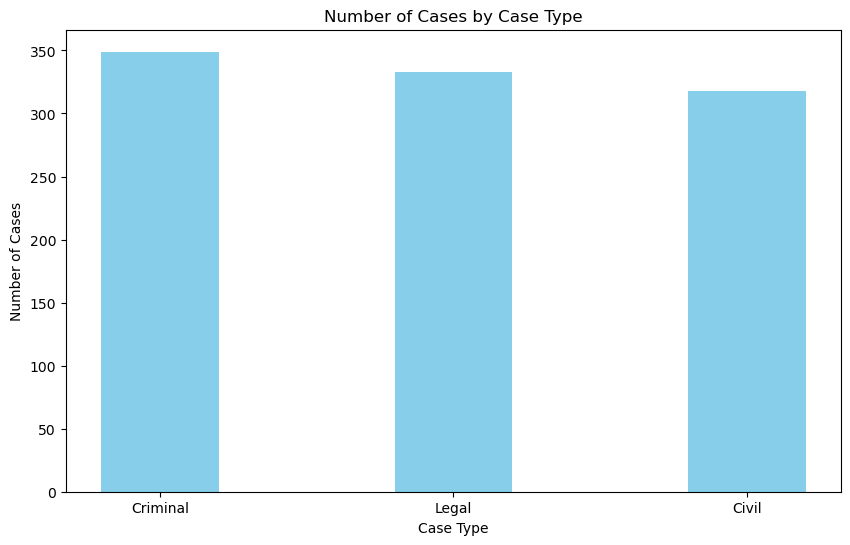

In [12]:
case_counts = df['Case type'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(case_counts.index, case_counts.values, color='skyblue', width=0.4)
plt.xlabel('Case Type')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Case Type')
plt.savefig('cases_by_type.png')
plt.show()

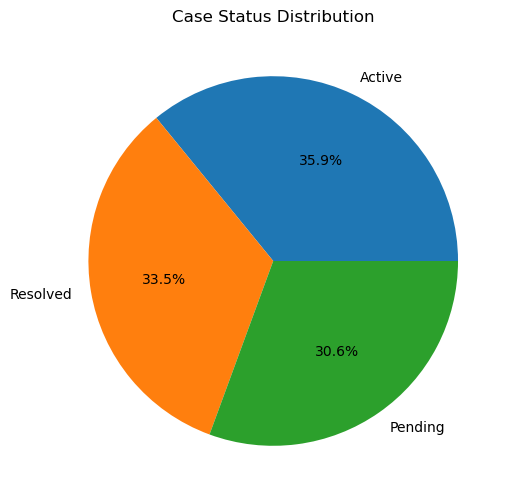

In [5]:
case_status_counts = df['Case status'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(case_status_counts.values, labels=case_status_counts.index, autopct='%1.1f%%')
plt.title('Case Status Distribution')
plt.savefig('case_status_distribution.png')
plt.show()


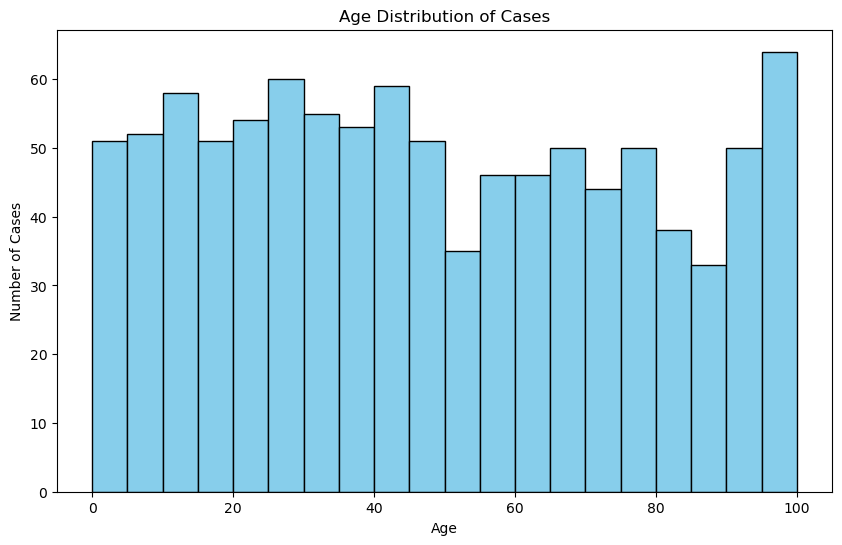

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Cases')
plt.title('Age Distribution of Cases')
plt.savefig('age_distribution.png')
plt.show()


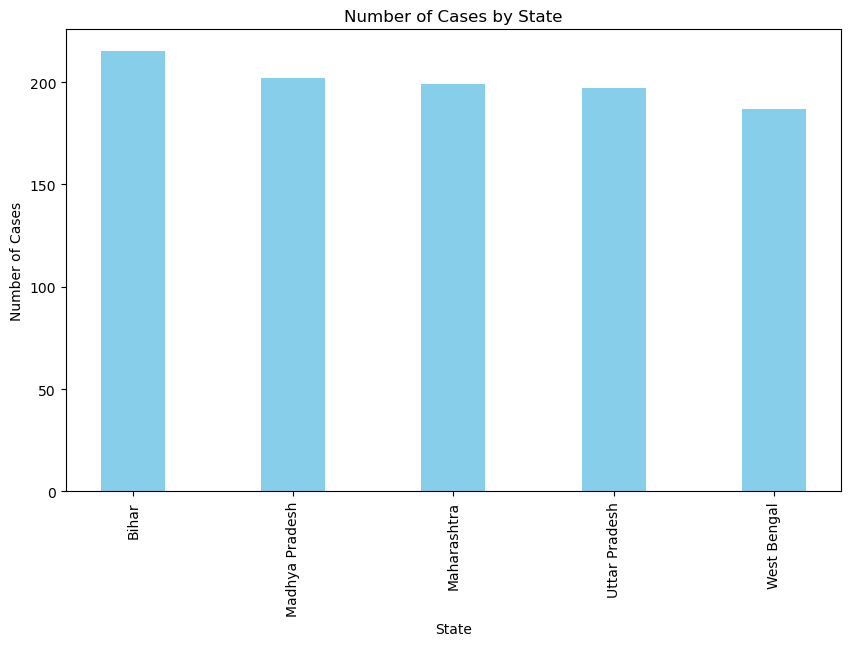

In [7]:
state_counts = df['State'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(state_counts.index, state_counts.values, color='skyblue', width=0.4)
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by State')
plt.xticks(rotation=90)
plt.savefig('cases_by_state.png')
plt.show()


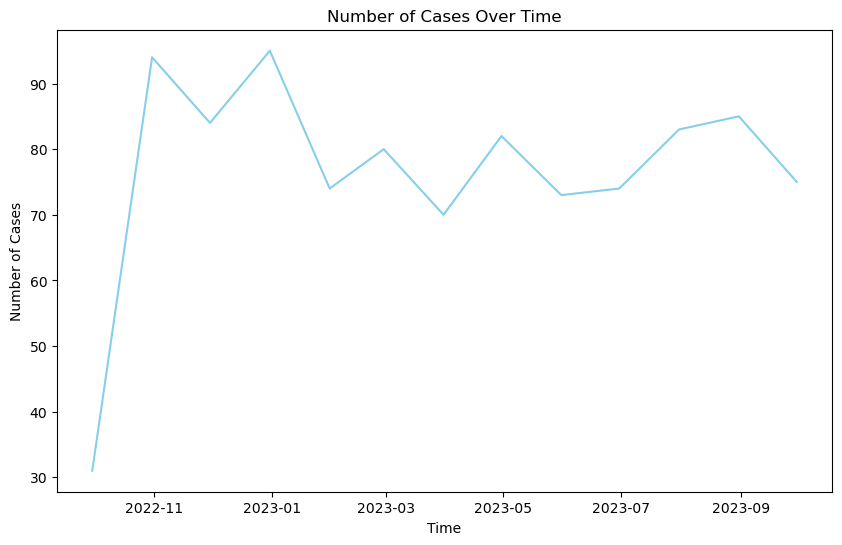

In [8]:
df['Date of Registration'] = pd.to_datetime(df['Date of Registration'])
cases_over_time = df.resample('M', on='Date of Registration').size()
plt.figure(figsize=(10, 6))
plt.plot(cases_over_time.index, cases_over_time.values, color='skyblue')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('Number of Cases Over Time')
plt.savefig('cases_over_time.png')
plt.show()


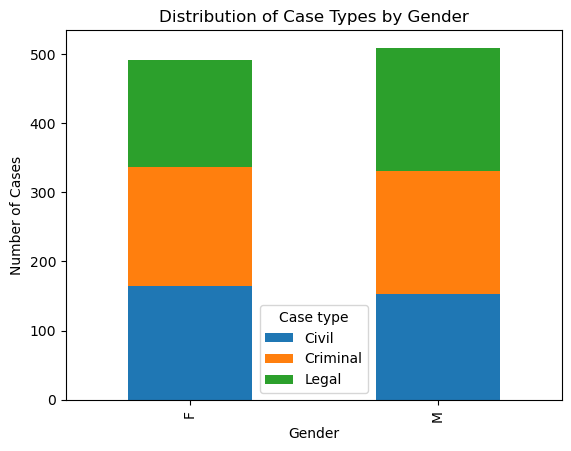

In [9]:
gender_case_type = df.groupby(['Gender', 'Case type']).size().unstack(fill_value=0)
gender_case_type.plot(kind='bar', stacked=True)
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.title('Distribution of Case Types by Gender')
plt.savefig('case_types_by_gender.png')


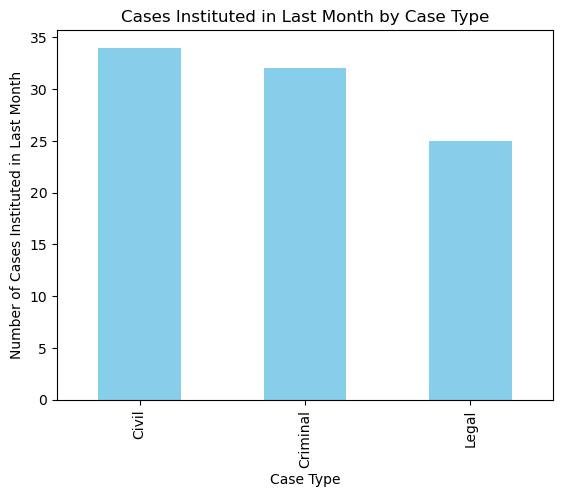

In [10]:
last_month_cases = df[df['Date of Registration'] > df['Date of Registration'].max() - pd.DateOffset(months=1)]
last_month_case_counts = last_month_cases['Case type'].value_counts()
last_month_case_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Case Type')
plt.ylabel('Number of Cases Instituted in Last Month')
plt.title('Cases Instituted in Last Month by Case Type')
plt.show()

<Axes: >

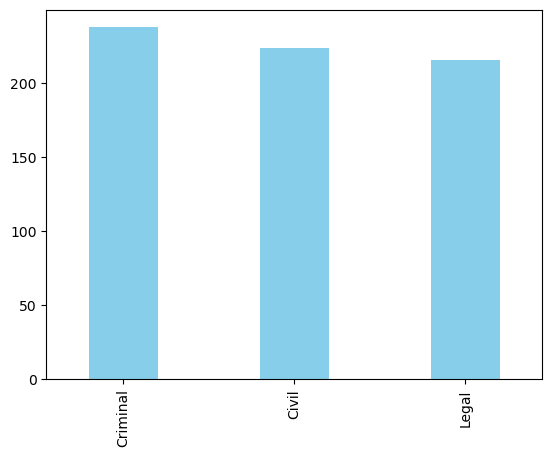

In [11]:
senior_woman_cases = df[(df['Age'] >= 60) | (df['Gender'] == 'F')]
senior_woman_case_counts = senior_woman_cases['Case type'].value_counts()
senior_woman_case_counts.plot(kind='bar', color='skyblue', width=0.4)
